In [ ]:
# Klasztercímkék mentése user_clusters.csv, hogy össze tudjam hasonlíani az egyéniés klaszter alapú LSTM eredményeket

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Adat betöltése és előkészítés
df = pd.read_csv("df_test_10k.csv", parse_dates=["date"])

# csak a szükséges oszlopokat tartsuk meg
user_features = df.groupby("uid").agg(
    mean_rg=("radius_of_gyration", "mean"),
    std_rg=("radius_of_gyration", "std"),
    mean_daily_rg=("daily_radius_of_gyration", "mean"),
    uniq_cells=("unique_cells_count", "mean"),
    frac_home=("is_home", "mean"),
    frac_work=("is_workplace", "mean"),
    weekend_ratio=("date", lambda x: (x.dt.dayofweek >= 5).mean()),
    mean_hour=("date", lambda x: x.dt.hour.mean()),
    mean_temp=("temperature", "mean"),
    std_temp=("temperature", "std"),
    mean_rain=("rain", "mean")
).fillna(0)

# Skálázás és klaszterezés 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features["cluster"] = kmeans.fit_predict(X_scaled)

#  Mentés a felhasználói klasztercímkékkel
user_clusters = user_features[["cluster"]].reset_index()
user_clusters.to_csv("user_clusters.csv", index=False)
print("✅ Klasztercímkék elmentve: user_clusters.csv")

In [ ]:
# Egyéni eredmények és klaszterek összekapcsolása (results_checkpoint.csv  +  user_clusters.csv) = > results_checkpoint_with_clusters.csv
results_df = pd.read_csv("results_checkpoint.csv")
clusters_df = pd.read_csv("user_clusters.csv")

results_w_cluster = results_df.merge(clusters_df, on="uid", how="left")

# új CSV mentése
results_w_cluster.to_csv("results_checkpoint_with_clusters.csv", index=False)
print("✅ results_checkpoint_with_clusters.csv létrehozva!")


🔹 Súlyozott átlagos accuracy (egéni): 0.3349
🔹 Súlyozott átlagos top5_accuracy (egéni): 0.5896

📊 Összevetés klaszterenként:

   cluster  users_in_cluster  accuracy  mean_acc  acc_diff  top5_accuracy  \
0        0              5169  0.276054  0.317040 -0.040985       0.619433   
1        1              2400  0.225228  0.186699  0.038529       0.561890   
2        2              2163  0.441014  0.538638 -0.097624       0.799125   
3        3               268  0.237569  0.361275 -0.123707       0.499744   

   mean_top5  top5_diff  
0   0.598973   0.020461  
1   0.372206   0.189684  
2   0.803486  -0.004361  
3   0.628590  -0.128846  


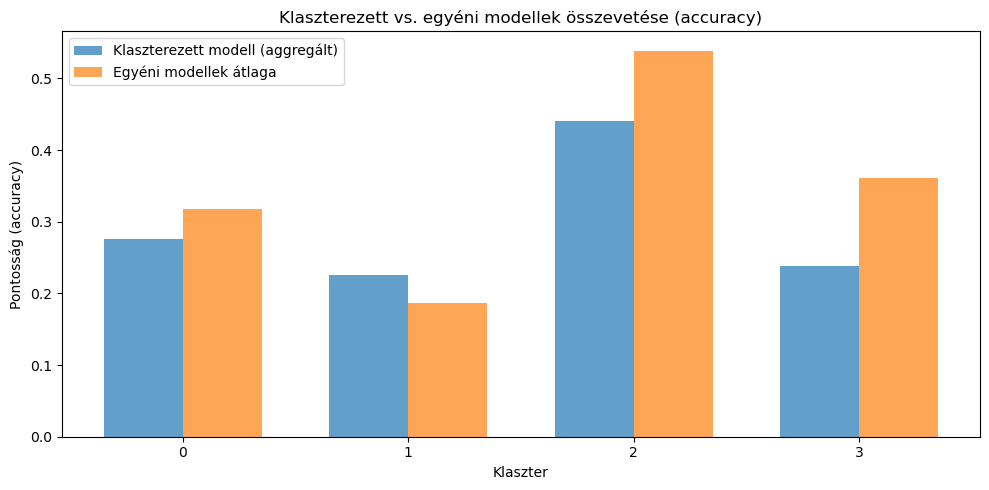

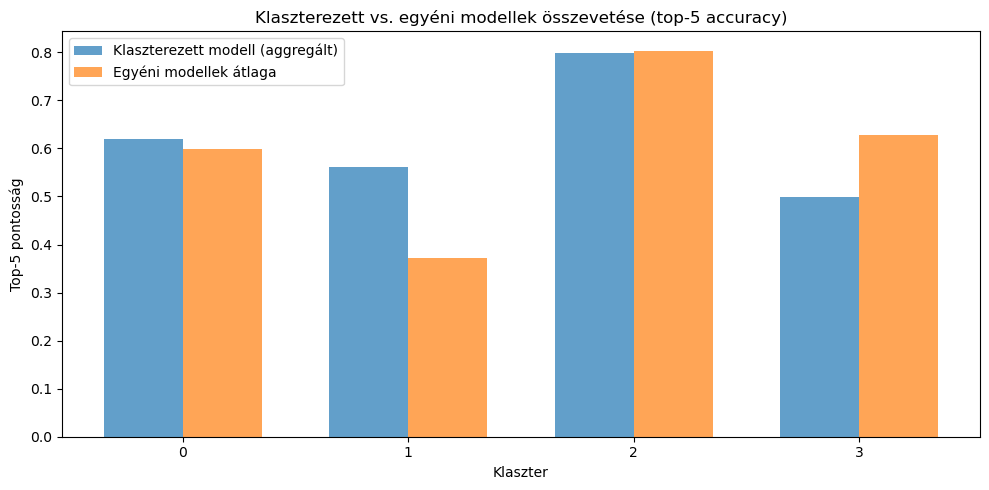

In [ ]:
# ===============================
# VIZUALIZÁCIÓK 1.
# ===============================

import pandas as pd
import matplotlib.pyplot as plt

# Beolvasás
cluster_df = pd.read_csv("results_clusters.csv")
checkpoint_df = pd.read_csv("results_checkpoint_with_clusters.csv")

# Egyéni eredmények aggregálása klaszterenként
cluster_stats = (
    checkpoint_df.groupby("cluster")
    .agg(
        users_in_cluster=("uid", "count"),
        mean_acc=("accuracy", "mean"),
        mean_top5=("top5_accuracy", "mean")
    )
    .reset_index()
)

# Súlyozott globális átlag (nem kötelező, de informatív)
total_users = cluster_stats["users_in_cluster"].sum()
weighted_acc = (cluster_stats["mean_acc"] * cluster_stats["users_in_cluster"]).sum() / total_users
weighted_top5 = (cluster_stats["mean_top5"] * cluster_stats["users_in_cluster"]).sum() / total_users

print(f"\n🔹 Súlyozott átlagos accuracy (egéni): {weighted_acc:.4f}")
print(f"🔹 Súlyozott átlagos top5_accuracy (egéni): {weighted_top5:.4f}")

# Merge a klaszter aggregátummal
compare_df = pd.merge(cluster_df, cluster_stats, on="cluster", how="inner")

# Különbségek kiszámítása
compare_df["acc_diff"] = compare_df["accuracy"] - compare_df["mean_acc"]
compare_df["top5_diff"] = compare_df["top5_accuracy"] - compare_df["mean_top5"]

# Eredmény táblázat
print("\n📊 Összevetés klaszterenként:\n")
print(compare_df[[
    "cluster",
    "users_in_cluster",
    "accuracy", "mean_acc", "acc_diff",
    "top5_accuracy", "mean_top5", "top5_diff"
]])

# Vizualizáció
plt.figure(figsize=(10,5))
bar_width = 0.35
x = range(len(compare_df))

plt.bar(x, compare_df["accuracy"], width=bar_width, label="Klaszterezett modell (aggregált)", alpha=0.7)
plt.bar([i + bar_width for i in x], compare_df["mean_acc"], width=bar_width, label="Egyéni modellek átlaga", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], compare_df["cluster"])
plt.xlabel("Klaszter")
plt.ylabel("Pontosság (accuracy)")
plt.title("Klaszterezett vs. egyéni modellek összevetése (accuracy)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Második grafikon: top-5 accuracy
plt.figure(figsize=(10,5))
plt.bar(x, compare_df["top5_accuracy"], width=bar_width, label="Klaszterezett modell (aggregált)", alpha=0.7)
plt.bar([i + bar_width for i in x], compare_df["mean_top5"], width=bar_width, label="Egyéni modellek átlaga", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], compare_df["cluster"])
plt.xlabel("Klaszter")
plt.ylabel("Top-5 pontosság")
plt.title("Klaszterezett vs. egyéni modellek összevetése (top-5 accuracy)")
plt.legend()
plt.tight_layout()
plt.show()

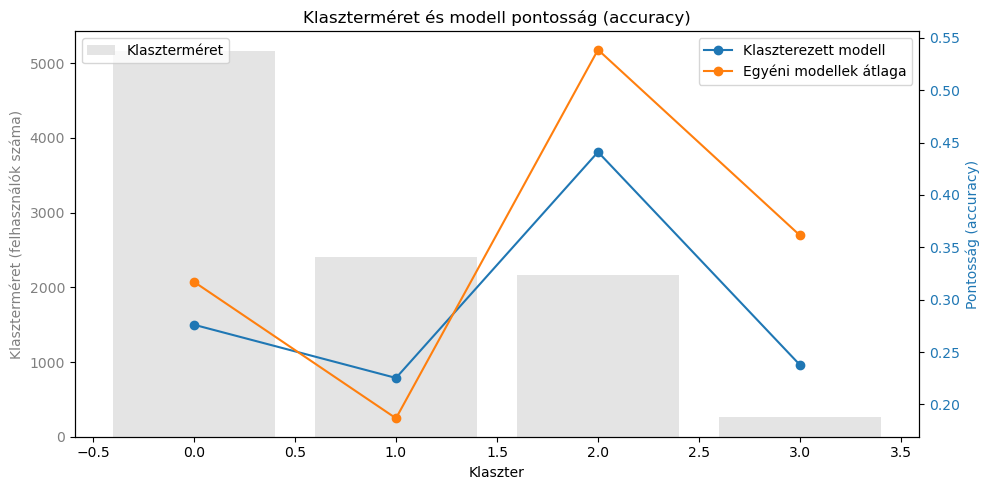

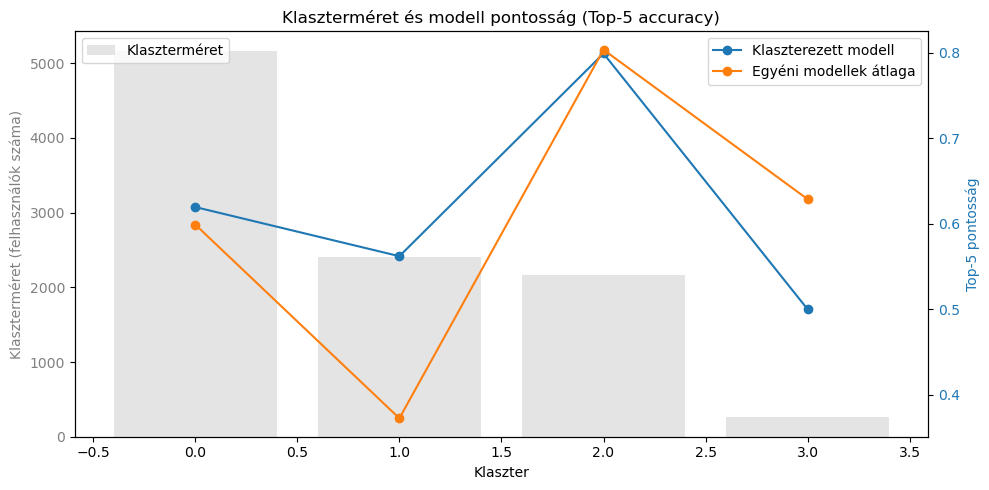

In [4]:
# ===============================
# VIZUALIZÁCIÓK 2.
# ===============================

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# Bar chart: klaszterméret
ax1.bar(compare_df["cluster"], compare_df["users_in_cluster"], color="lightgray", alpha=0.6, label="Klaszterméret")

# Line plot: pontosságok
ax2.plot(compare_df["cluster"], compare_df["accuracy"], marker="o", label="Klaszterezett modell", color="tab:blue")
ax2.plot(compare_df["cluster"], compare_df["mean_acc"], marker="o", label="Egyéni modellek átlaga", color="tab:orange")

ax1.set_xlabel("Klaszter")
ax1.set_ylabel("Klaszterméret (felhasználók száma)", color="gray")
ax2.set_ylabel("Pontosság (accuracy)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="gray")
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.title("Klaszterméret és modell pontosság (accuracy)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 2. ÁBRA TOP5


fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# --- Szürke oszlopok: klaszterméret ---
ax1.bar(compare_df["cluster"], compare_df["users_in_cluster"],
        color="lightgray", alpha=0.6, label="Klaszterméret")

# --- Kék és narancs pontvonal: top-5 pontosság ---
ax2.plot(compare_df["cluster"], compare_df["top5_accuracy"],
         'o-', color="tab:blue", label="Klaszterezett modell")
ax2.plot(compare_df["cluster"], compare_df["mean_top5"],
         'o-', color="tab:orange", label="Egyéni modellek átlaga")

# --- Címkék és stílus ---
ax1.set_xlabel("Klaszter")
ax1.set_ylabel("Klaszterméret (felhasználók száma)", color="gray")
ax2.set_ylabel("Top-5 pontosság", color="tab:blue")

ax1.tick_params(axis='y', labelcolor="gray")
ax2.tick_params(axis='y', labelcolor="tab:blue")

plt.title("Klaszterméret és modell pontosság (Top-5 accuracy)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()